In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import time
import random

## Environments (Planet)

In [7]:
# U D L R
ACTIONS = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
class Planet(object):
    def __init__(self):
        # start with defining your planet
        self.planet = np.zeros((6, 6))
        #POIs
        self.planet[5, 5] = 3
        self.planet[5, 0] = 3
        self.planet[2, 1] = 3
        #Robots
        self.planet[1, 2] = 2
        self.planet[3, 3] = 2
        self.planet[0, 4] = 2
        #Traps
        self.planet[3, 4] = 1
        self.planet[4, 2] = 1
        self.planet[0, 2] = 1
        self.planet[2, 0] = 1
        
        self.robot_positions = [(1,2),(3,3),(0,4)]
        self.robot_0_done = False
        self.robot_1_done = False
        self.robot_2_done = False
        self.steps = 0 # contains num steps robot took
        self.allowed_states = None # for now, this is none
        self.construct_allowed_states() 
    def is_allowed_move(self, state, action):
        y, x = state
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        # moving off the board
        if y < 0 or x < 0 or y > 5 or x > 5:
             return False
        # moving into empty space or POI
        if self.planet[y, x] == 0 or self.planet[y, x] == 3:
            return True
        else:
            return False
    def construct_allowed_states(self):
        allowed_states = {}
        for y, row in enumerate(self.planet):
            for x, col in enumerate(row):
                # iterate through all valid spaces
                if self.planet[(y,x)] != 1:
                    allowed_states[(y,x)] = []
                    for action in ACTIONS:
                        if self.is_allowed_move((y, x), action):
                            allowed_states[(y,x)].append(action)
        self.allowed_states = allowed_states
    def update_planet(self, action, robot_num):
        y, x = self.robot_positions[robot_num]
        old_y, old_x = self.robot_positions[robot_num]
        y += ACTIONS[action][0]
        x += ACTIONS[action][1]
        if self.planet[y, x] != 2:
            self.planet[old_y, old_x] = 0
            self.robot_positions[robot_num] = (y, x)
            self.planet[y, x] = 2        
    def is_game_over(self):
        if self.robot_0_done == True and self.robot_1_done == True and self.robot_2_done == True:
            return True
        return False
    def give_reward(self, state_history, robot_num):
        location = self.robot_positions[robot_num]
        if robot_num == 0 and location == (2,1):
            self.robot_0_done = True
            return 1
        elif robot_num == 1 and location == (5,0):
            self.robot_1_done = True
            return 1
        elif robot_num == 2 and location == (5,5):
            self.robot_2_done = True
            return 1
        else:
            return 0
    def get_state_and_reward(self, state_history, robot_num):
        return self.robot_positions[robot_num], self.give_reward(state_history, robot_num)
    def simulate(self):
        
        return self.planet

## Agent Class (Robots)

In [8]:
# U D L R
ACTIONS = {0: (-1, 0), 1: (1, 0), 2: (0, -1), 3: (0, 1)}
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2, robot_num=9):
        self.state_history = [((0, 0), 0, 0, (0, 0))] # state, reward, action, next_state
        self.alpha = alpha
        self.random_factor = random_factor
        self.robot_num = robot_num
        
        # start the rewards table
        self.qtable = np.random.rand(36, 4).tolist()
        
    def init_reward(self, states):
        for i, row in enumerate(states):
            for j, col in enumerate(row):
                self.G[(j,i)] = np.random.uniform(high=1.0, low=0.9)
    def update_state_history(self, state, reward, action, next_state):
        self.state_history.append((state, reward, action, next_state))
    def learn(self):
        a = self.alpha
        g = 0.9
        for state, reward, action, next_state in reversed(self.state_history):
            y, x = state
            state_index = (y * 5) + x
            current_qReward =  self.qtable[state_index][action]
            Ny, Nx = next_state
            next_state_index = (Ny * 5) + Nx
            #self.qtable[state_index][action] = reward + a * max(self.qtable[next_state_index])
            self.qtable[state_index][action] = current_qReward + (a * (reward + (g * (max(self.qtable[next_state_index]))) - current_qReward))
        self.state_history = [] # reset the state_history
        self.random_factor -= 10e-5 # decrease random_factor
    def choose_action(self, state, allowed_moves, state_history):
        next_move = None
        n = np.random.uniform()
        if n < self.random_factor:
            next_move = np.random.choice(allowed_moves)
            valid = True
        else:
            maxG = -10e15 # some really small random number
            y, x = state
            state_index = (y * 5) + x 
            next_move = self.qtable[state_index].index(max(self.qtable[state_index]))
            if next_move in allowed_moves:
                valid = True
            else:
                valid = False

        return next_move, valid

## Learning Loop

0
1000
2000
3000
4000


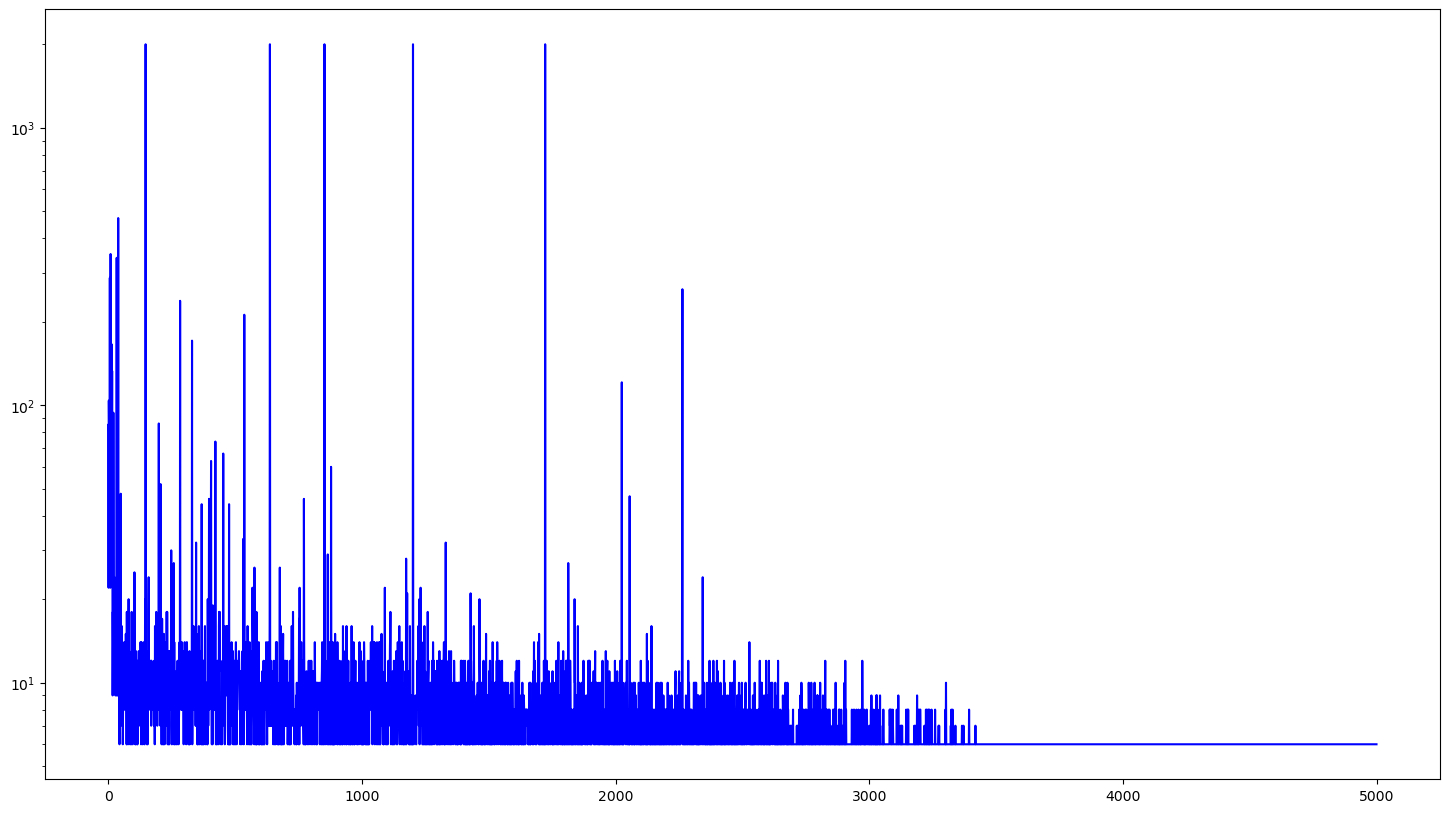

In [9]:
if __name__ == '__main__':  
    planet = Planet()
    robot_0 = Agent(planet.planet, alpha=0.1, random_factor=0.35, robot_num=0)
    robot_1 = Agent(planet.planet, alpha=0.1, random_factor=0.35, robot_num=1)
    robot_2 = Agent(planet.planet, alpha=0.1, random_factor=0.35, robot_num=2)
    swarm = [robot_0, robot_1, robot_2]
    moveHistory = []
    for i in range(5000):
        if i % 1000 == 0:            
            print(i)
         
        test = False
        while not planet.is_game_over():
            n = 0
            while n < 3:
                robot = swarm[n]
                if not ((n == 0 and planet.robot_0_done == True) or (n == 1 and planet.robot_1_done == True) or (n == 2 and planet.robot_2_done == True)):
                    sHistory = robot.state_history
                    state, _ = planet.get_state_and_reward(sHistory, robot.robot_num) # get the current state
                    action, valid = robot.choose_action(state, planet.allowed_states[state], sHistory) # choose an action (explore or exploit)
                    if valid:
                        planet.update_planet(action, robot.robot_num) # update the planet according to the action
                    next_state, reward = planet.get_state_and_reward(sHistory, robot.robot_num) # get the new state and reward                
                    robot.update_state_history(state, reward, action, next_state) # update the robot memory with state and reward
                n += 1
            planet.steps += 1
            if planet.steps > 2000:
                # end the robot if it takes too long to find the goal
                test = True
                planet.robot_0_done = True
                planet.robot_1_done = True
                planet.robot_2_done = True          
            
        # robot should learn after every episode
        m = 0
        while m < 3:
            robot = swarm[m]
            robot.learn()
            m += 1
        moveHistory.append(planet.steps) # get a history of number of steps taken to plot later
        planet = Planet() # reinitialize the planet
        
plt.figure(figsize=(18, 10))
plt.semilogy(moveHistory, color="b")
plt.show()

## Testing and Simulation

0


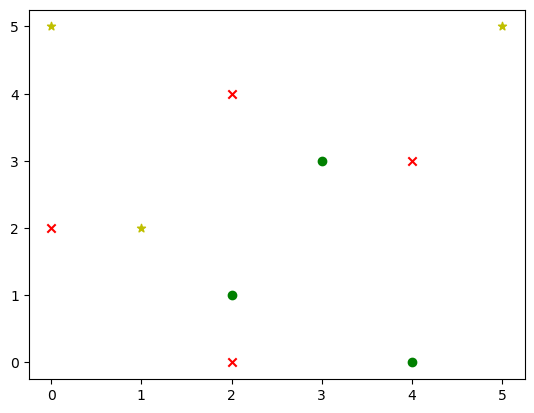

0
0


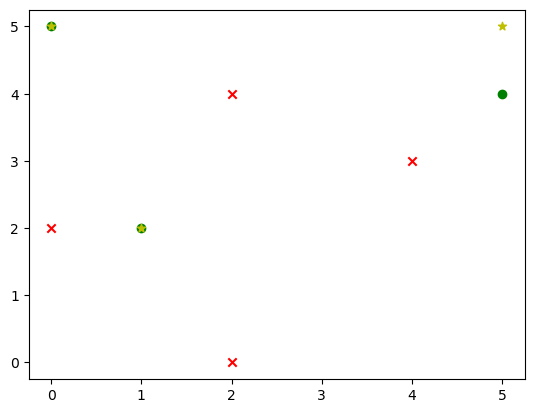

In [11]:
testHistory = []
for i in range(1):
        if i % 100 == 0:            
            print(i)
        
        planet = Planet()
        tx, ty, px, py, rx, ry, x_history, y_history = [], [], [], [], [], [], [], []
        
        for y, row in enumerate(planet.planet):
            for x, col in enumerate(row):
                if planet.planet[(y,x)] == 1:
                    tx.append(x)
                    ty.append(y)
                if planet.planet[(y,x)] == 3:
                    px.append(x)
                    py.append(y)
                if planet.planet[(y,x)] == 2:
                    rx.append(x)
                    ry.append(y)
        x_history.append(rx)
        y_history.append(ry)
        plt.scatter(rx, ry, marker = 'o', color = 'g') 
        plt.scatter(tx, ty, marker = 'x', color = 'r') 
        plt.scatter(px, py, marker = '*', color = 'y') 
        plt.show()
                
        while not planet.is_game_over():
            n = 0
            while n < 3:
                robot = swarm[n]
                if not ((n == 0 and planet.robot_0_done == True) or (n == 1 and planet.robot_1_done == True) or (n == 2 and planet.robot_2_done == True)):
                    sHistory = robot.state_history
                    state, _ = planet.get_state_and_reward(sHistory, robot.robot_num) # get the current state
                    action, valid = robot.choose_action(state, planet.allowed_states[state], sHistory) # choose an action (explore or exploit)
                    if valid:
                        planet.update_planet(action, robot.robot_num) # update the planet according to the action
                    next_state, reward = planet.get_state_and_reward(sHistory, robot.robot_num) # get the new state and reward
                    robot.update_state_history(state, reward, action, next_state) # update the robot memory with state and reward
                n += 1
            planet.steps += 1
            if planet.steps > 2000:
                planet.robot_0_done = True
                planet.robot_1_done = True
                planet.robot_2_done = True
            
            
            rx = []
            ry = []
            for y, row in enumerate(planet.planet):
                for x, col in enumerate(row):
                    if planet.planet[(y,x)] == 2:
                        rx.append(x)
                        ry.append(y)
            x_history.append(rx)
            y_history.append(ry)
                                    
        testHistory.append(planet.steps) # get a history of number of steps taken to plot later
        
        fig, ax = plt.subplots()
        ax.set_xlim([-1, 6])
        ax.set_ylim([-1, 6])
        
        def animate(i):
            if i % 10 == 0:            
                print(i) 
            plt.clf()
            plt.scatter(x_history[i], y_history[i], marker = 'o', color = 'g') 
            plt.scatter(tx, ty, marker = 'x', color = 'r') 
            plt.scatter(px, py, marker = '*', color = 'y') 
            return fig,

        ani = animation.FuncAnimation(fig, animate, repeat=True,
                                            frames=len(x_history) - 1, interval=500)        
        # To save the animation using Pillow as a gif
        writer = animation.PillowWriter(fps=3,
                                     metadata=dict(artist='Me'),
                                     bitrate=1800)
        ani.save('path.gif', writer=writer)
        plt.show()
        